In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

from ucimlrepo import fetch_ucirepo
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer


from trabalho_ic_aplicada.models import aux
from trabalho_ic_aplicada.models.reg_perceptron import treinar_perceptron_reg, prever_perceptron_reg

In [3]:
# fetch dataset
real_estate_valuation = fetch_ucirepo(id=477)

features = real_estate_valuation.variables.iloc[1:, 0].values
# data (as pandas dataframes)
X = real_estate_valuation.data.features.to_numpy()

# Removendo a primeira coluna (X1 transaction date) que não é um atributo relevante, segundo analise.
X = X[:, 1:]

y = real_estate_valuation.data.targets.to_numpy().ravel()


k_fold = aux.validacao_cruzada_kfold(X,y,k=10)


Erro Quadrático Médio (EQM): 249.5019 ± 58.4897
Raiz do Erro Quadrático Médio (REQM): 15.6970 ± 1.7627
Hit rate 20%: 0.2950 ± 0.0386
Hit rate 10%: 0.1237 ± 0.0409

--- Coeficientes de Correlação (Real vs. Previsto) ---
Correlação Média (Treino): 0.4388 ± 0.0862
Correlação Média (Teste): 0.4219 ± 0.2380
Coeficiente de Determinação (R²): -0.3904 ± 0.1934

--- Análise de Gaussianidade dos Resíduos ---
Shapiro-Wilk (Treino): Estatística=0.9670, p-valor=0.0000
Shapiro-Wilk (Teste): Estatística=0.9681, p-valor=0.0000
Resíduos de treino NÃO seguem distribuição normal.


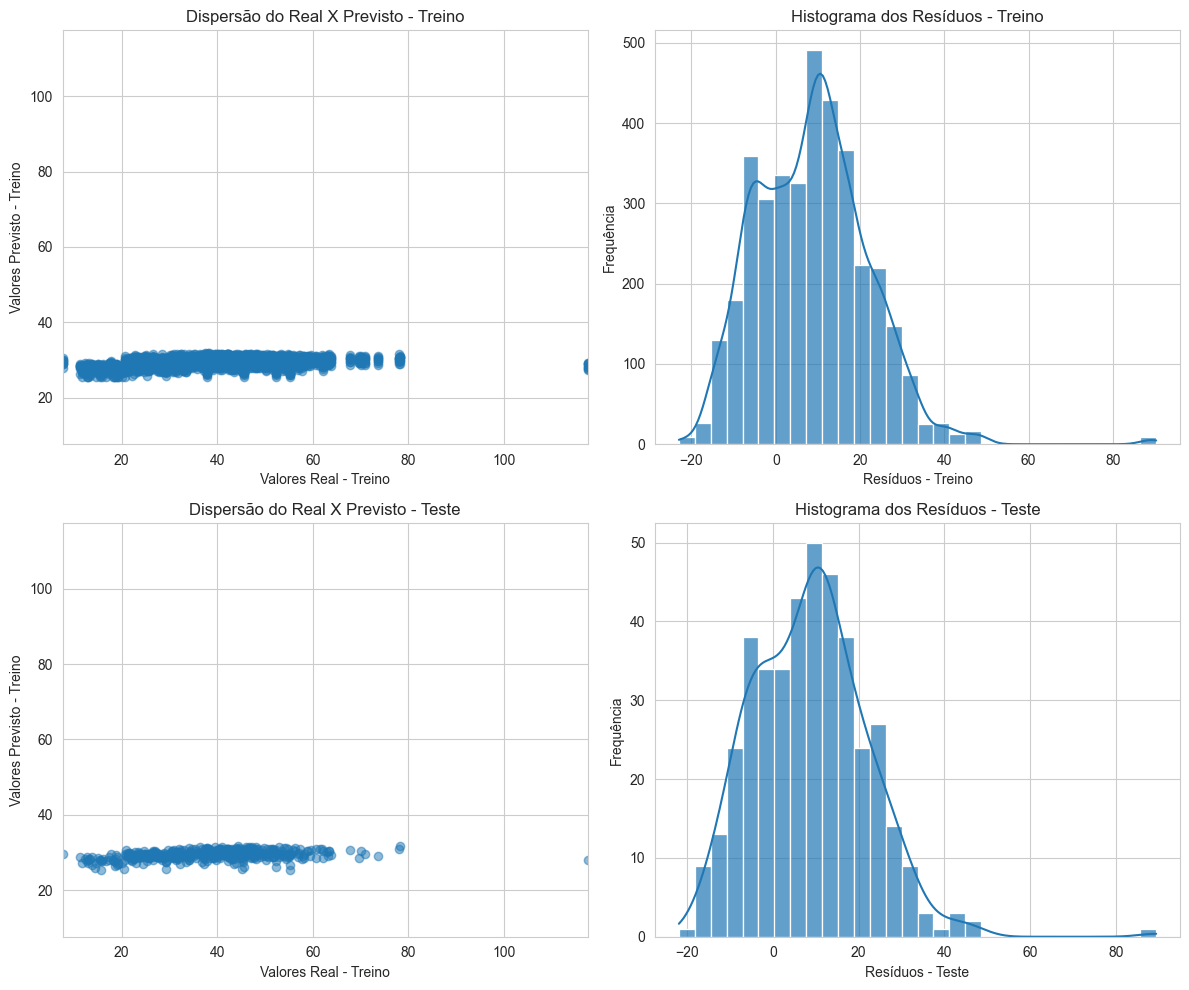

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def inicializar_pesos(n_features, n_outputs, n_hidden):
    """
    Inicializa as matrizes de peso para a MLP.
    """
    W = np.random.rand(n_hidden, n_features + 1) - 0.5
    M = np.random.rand(n_outputs, n_hidden + 1) - 0.5
    return W, M

def treinar_mlp_regressao(X_train, y_train, n_hidden, epochs, eta_i, eta_f, versbose=False):
    """
    Treina a MLP para um problema de REGRESSÃO.
    """
    n_samples, n_features = X_train.shape
    # Para regressão, a saída é geralmente uma única coluna
    n_outputs = y_train.shape[1] if y_train.ndim > 1 else 1

    W, M = inicializar_pesos(n_features, n_outputs, n_hidden)

    mse_history = []
    total_iterations = epochs * n_samples

    for epoch in range(epochs):
        permutation = np.random.permutation(n_samples)
        X_train_shuffled = X_train[permutation]
        y_train_shuffled = y_train[permutation]

        epoch_squared_error = 0.0

        for i in range(n_samples):
            x_sample = X_train_shuffled[i]
            y_target = y_train_shuffled[i]

            # --- Forward Pass ---
            X_b = np.insert(x_sample, 0, -1)
            Ui = W @ X_b
            Yi = np.tanh(Ui) # Não-linearidade na camada oculta
            Y_b = np.insert(Yi, 0, -1)
            Uk = M @ Y_b
            Ok = Uk # MUDANÇA 1: Ativação LINEAR na camada de saída

            # --- Cálculo do Erro ---
            Ek = y_target - Ok
            epoch_squared_error += 0.5 * np.sum(Ek**2)

            # --- Backward Pass ---
            # MUDANÇA 2: A derivada da função linear é 1
            DDk = Ek # O gradiente local da saída é o próprio erro

            Di = 0.5 * (1 - Yi**2)
            DDi = Di * (M[:, 1:].T @ DDk)

            # --- Atualização dos Pesos ---
            current_iteration = epoch * n_samples + i
            eta = eta_i - ((eta_i - eta_f) / total_iterations) * current_iteration

            DDk_col = DDk.reshape(-1, 1)
            Y_b_row = Y_b.reshape(1, -1)
            DDi_col = DDi.reshape(-1, 1)
            X_b_row = X_b.reshape(1, -1)

            M += eta * (DDk_col @ Y_b_row)
            W += eta * (DDi_col @ X_b_row)

        mse_history.append(epoch_squared_error / n_samples)
        if versbose: print(f"Época: {epoch + 1}/{epochs}, MSE: {mse_history[-1]:.6f}")

    return W, M, mse_history

def prever_mlp_regressao(X_test, W, M):
    """
    Realiza a predição de regressão usando pesos já treinados.
    """
    n_samples = X_test.shape[0]
    predictions = []

    for i in range(n_samples):
        x_sample = X_test[i]

        # Forward Pass
        X_b = np.insert(x_sample, 0, -1)
        Ui = W @ X_b
        Yi = np.tanh(Ui)
        Y_b = np.insert(Yi, 0, -1)
        Uk = M @ Y_b
        Ok = Uk # Saída linear
        predictions.append(Ok)

    return np.array(predictions).flatten()

# PARÂMETROS
N_HIDDEN_NEURONS = 10
LEARNING_RATE = 0.00001 # Taxas de aprendizado menores são comuns em regressão
EPOCHS = 50

# CARREGAMENTO DOS DADOS (Exemplo: Dataset de Imóveis)
# try:
#     # Tenta carregar o dataset de imóveis do trabalho TC1
#     # O arquivo Excel original foi convertido para CSV para facilitar.
#     df = pd.read_csv('real_estate.csv')
#     # Removendo colunas não-preditivas
#     df = df.drop(columns=['No', 'X1 transaction date'])
#
#     dados = df.iloc[:, :-1].values
#     alvos = df.iloc[:, -1].values
#
# except FileNotFoundError:
#     print("Arquivo 'real_estate.csv' não encontrado. Gerando dados sintéticos para demonstração.")
#     # Gerando uma função não-linear simples: y = sin(x1) + x2^2 + ruído
#     n_pontos = 400
#     dados = np.random.rand(n_pontos, 2) * 5
#     alvos = np.sin(dados[:, 0]) + dados[:, 1]**0.5 + np.random.randn(n_pontos) * 0.1

# # O usuário pediu para não se preocupar com normalização e divisão treino/teste.
# X_treino = dados
# # Garante que 'alvos' seja um vetor coluna
# y_treino = alvos.reshape(-1, 1)

# print(f"Dimensões dos dados de entrada: {X_treino.shape}")
# print(f"Dimensões dos alvos: {y_treino.shape}")
# print("-" * 30)

# Listas para métricas
eqms_iqr = []
reqms_iqr = []
r_quadrados_iqr = []
hit_rates_20_iqr = []
hit_rates_10_iqr = []

# Listas para resíduos e correlações
correlacoes_treino = []
correlacoes_teste = []

# Listas para análise final
y_trains = []
y_train_preds = []
y_tests = []
y_test_preds = []

# MSEs
historicos_mses = []

# Loop de validação cruzada
for k in range(len(k_fold)):
    # Dados de treino
    X_train_k = X[k_fold[k][0], :]
    y_train_k = y[k_fold[k][0]]

        # Normalização
    scaler = QuantileTransformer(n_quantiles=X_train_k.shape[0], output_distribution='uniform')
    X_train_k = scaler.fit_transform(X_train_k)

    # TREINAMENTO DO MODELO
    W_treinado, M_treinado, historico_mse = treinar_mlp_regressao(
        X_train_k, y_train_k,
        n_hidden=N_HIDDEN_NEURONS,
        epochs=EPOCHS,
        eta_i=LEARNING_RATE,
        eta_f=LEARNING_RATE
    )

    historicos_mses.append(historico_mse)

    # PREDIÇÃO E AVALIAÇÃO (MUDANÇA 3: Novas Métricas)
    y_pred_train = prever_mlp_regressao(X_train_k, W_treinado, M_treinado)
    corr_treino = np.corrcoef(y_train_k.flatten(), y_pred_train.flatten())[0, 1]
    correlacoes_treino.append(corr_treino)


    X_test_k = X[k_fold[k][1], :]
    y_test_k = y[k_fold[k][1]]
    X_test_k = scaler.transform(X_test_k)

    # Previsão teste
    y_pred_test = prever_mlp_regressao(X_test_k, W_treinado, M_treinado)
    corr_teste = np.corrcoef(y_test_k.flatten(), y_pred_test.flatten())[0, 1]
    correlacoes_teste.append(corr_teste)


    # Armazenar para análises finais
    y_trains.extend(y_train_k)
    y_train_preds.extend(y_pred_train)
    y_tests.extend(y_test_k)
    y_test_preds.extend(y_pred_test)

    # Cálculo de métricas e resíduos
    eqm, reqm, r2, hit20, hit10, _ = aux.calcular_metricas(y_test_k, y_pred_test, aux)
    eqms_iqr.append(eqm)
    reqms_iqr.append(reqm)
    r_quadrados_iqr.append(r2)
    hit_rates_20_iqr.append(hit20)
    hit_rates_10_iqr.append(hit10)

# Converter para array
y_trains = np.array(y_trains)
y_train_preds = np.array(y_train_preds)
y_tests = np.array(y_tests)
y_test_preds = np.array(y_test_preds)

# Imprimir métricas
aux.imprimir_metricas(eqms_iqr, reqms_iqr, r_quadrados_iqr, hit_rates_20_iqr, hit_rates_10_iqr)

# Correlações
aux.imprimir_correlacoes(correlacoes_treino, correlacoes_teste, r_quadrados_iqr)

# Análise dos resíduos + gráfico + shapiro
aux.analisar_residuos(
    y_trains, y_train_preds,
    y_tests, y_test_preds,
    aux,
    titulo='Regressão MLP (MLP Regression 1H)'
)


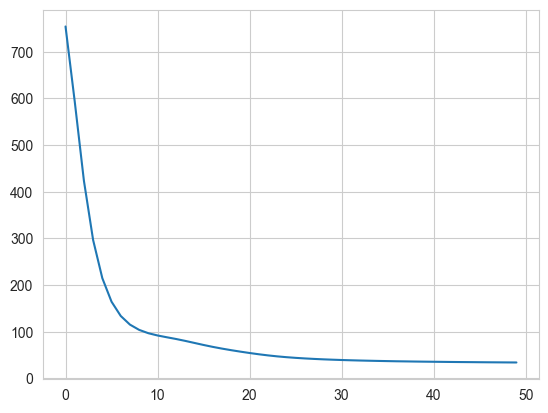

In [8]:
plt.plot(np.mean(historicos_mses, axis=0))

Generating synthetic data for demonstration...
Data shape: X=(400, 2), y=(400, 1)
Network architecture: [2, 20, 10, 1]
Hidden activation: leaky_relu
Output activation: linear
--------------------------------------------------


Epoch 100/100 | MSE: 0.006572: 100%|██████████| 100/100 [00:05<00:00, 17.43it/s]



Final MSE: 0.012863
Correlation: 0.991900


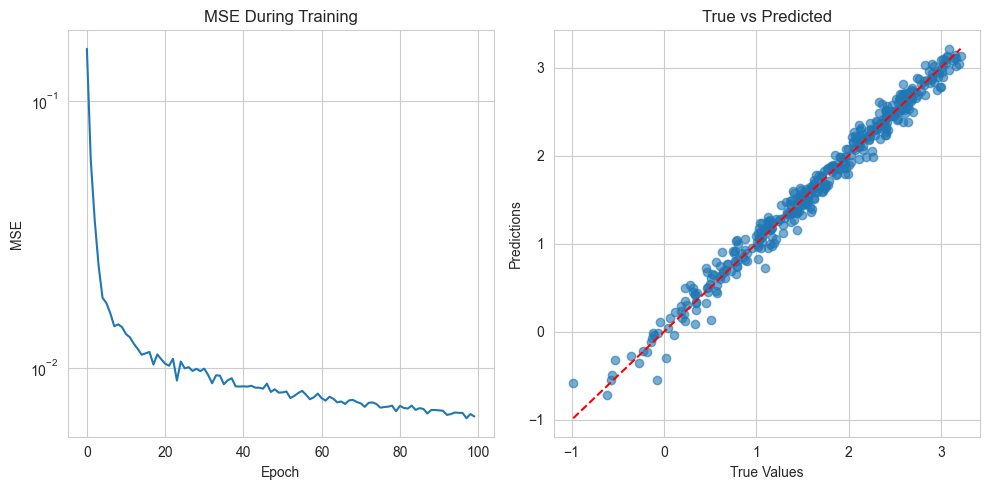

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange

# ============================================================================
# ACTIVATION FUNCTIONS AND THEIR DERIVATIVES
# ============================================================================

def tanh_activation(x):
    """Hyperbolic tangent activation function"""
    return np.tanh(x)

def tanh_derivative(y):
    """Derivative of tanh (given the output y = tanh(x))"""
    return 1 - y**2

def sigmoid_activation(x):
    """Sigmoid activation function"""
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))  # Clip to prevent overflow

def sigmoid_derivative(y):
    """Derivative of sigmoid (given the output y = sigmoid(x))"""
    return y * (1 - y)

def relu_activation(x):
    """ReLU activation function"""
    return np.maximum(0, x)

def relu_derivative(y):
    """Derivative of ReLU (given the output y = relu(x))"""
    return (y > 0).astype(float)

def linear_activation(x):
    """Linear activation function"""
    return x

def linear_derivative(y):
    """Derivative of linear activation"""
    return np.ones_like(y)

def leaky_relu_activation(x, alpha=0.01):
    """Leaky ReLU activation function"""
    return np.where(x > 0, x, alpha * x)

def leaky_relu_derivative(y, alpha=0.01):
    """Derivative of Leaky ReLU"""
    return np.where(y > 0, 1, alpha)

# Dictionary mapping activation names to functions
ACTIVATION_FUNCTIONS = {
    'tanh': (tanh_activation, tanh_derivative),
    'sigmoid': (sigmoid_activation, sigmoid_derivative),
    'relu': (relu_activation, relu_derivative),
    'linear': (linear_activation, linear_derivative),
    'leaky_relu': (leaky_relu_activation, leaky_relu_derivative)
}

# ============================================================================
# NETWORK INITIALIZATION
# ============================================================================

def initialize_weights(layer_sizes):
    """
    Initialize weight matrices for all layers.

    Args:
        layer_sizes: List containing the number of neurons in each layer
                    [input_features, hidden1, hidden2, ..., output]

    Returns:
        List of weight matrices (including bias terms)
    """
    weights = []

    for i in range(len(layer_sizes) - 1):
        # Xavier/Glorot initialization
        fan_in = layer_sizes[i]
        fan_out = layer_sizes[i + 1]
        limit = np.sqrt(6 / (fan_in + fan_out))

        # Add 1 for bias term
        W = np.random.uniform(-limit, limit, (layer_sizes[i + 1], layer_sizes[i] + 1))
        weights.append(W)

    return weights

# ============================================================================
# FORWARD PASS
# ============================================================================

def forward_pass(x_sample, weights, hidden_activation='tanh', output_activation='linear'):
    """
    Perform forward pass through the network.

    Args:
        x_sample: Input sample (1D array)
        weights: List of weight matrices
        hidden_activation: Activation function for hidden layers
        output_activation: Activation function for output layer

    Returns:
        activations: List of activations for each layer
        z_values: List of pre-activation values
    """
    activations = [x_sample]  # Input layer
    z_values = []  # Pre-activation values

    # Get activation functions
    hidden_func, _ = ACTIVATION_FUNCTIONS[hidden_activation]
    output_func, _ = ACTIVATION_FUNCTIONS[output_activation]

    current_input = x_sample

    for i, W in enumerate(weights):
        # Add bias term
        current_input_with_bias = np.insert(current_input, 0, -1)

        # Linear combination
        z = W @ current_input_with_bias
        z_values.append(z)

        # Apply activation function
        if i == len(weights) - 1:  # Output layer
            activation = output_func(z)
        else:  # Hidden layers
            activation = hidden_func(z)

        activations.append(activation)
        current_input = activation

    return activations, z_values

# ============================================================================
# BACKWARD PASS
# ============================================================================

def backward_pass(activations, z_values, weights, target, hidden_activation='tanh', output_activation='linear'):
    """
    Perform backward pass (backpropagation).

    Args:
        activations: List of activations from forward pass
        z_values: List of pre-activation values
        weights: List of weight matrices
        target: Target output
        hidden_activation: Activation function for hidden layers
        output_activation: Activation function for output layer

    Returns:
        gradients: List of gradients for each weight matrix
        error: Output error for MSE calculation
    """
    # Get derivative functions
    _, hidden_deriv = ACTIVATION_FUNCTIONS[hidden_activation]
    _, output_deriv = ACTIVATION_FUNCTIONS[output_activation]

    gradients = [np.zeros_like(W) for W in weights]

    # Output layer error
    output = activations[-1]
    error = target - output

    # Output layer gradient (delta)
    if output_activation == 'linear':
        delta = error  # For linear activation, derivative is 1
    else:
        delta = error * output_deriv(output)

    # Backpropagate through layers
    for i in reversed(range(len(weights))):
        # Current layer activation (with bias)
        if i == 0:
            current_activation = np.insert(activations[i], 0, -1)  # Input layer
        else:
            current_activation = np.insert(activations[i], 0, -1)  # Hidden layer

        # Calculate gradient for current layer
        delta_col = delta.reshape(-1, 1)
        activation_row = current_activation.reshape(1, -1)
        gradients[i] = delta_col @ activation_row

        # Propagate error to previous layer (if not input layer)
        if i > 0:
            # Remove bias weights for backpropagation
            W_no_bias = weights[i][:, 1:]
            error_prev = W_no_bias.T @ delta

            # Apply derivative of hidden activation
            if hidden_activation == 'tanh':
                delta = error_prev * hidden_deriv(activations[i])
            elif hidden_activation == 'sigmoid':
                delta = error_prev * hidden_deriv(activations[i])
            elif hidden_activation == 'relu':
                delta = error_prev * hidden_deriv(activations[i])
            elif hidden_activation == 'leaky_relu':
                delta = error_prev * leaky_relu_derivative(activations[i])
            else:  # linear
                delta = error_prev * hidden_deriv(activations[i])

    return gradients, error

# ============================================================================
# TRAINING FUNCTION
# ============================================================================

def train_mlp_regression(X_train, y_train, layer_sizes, epochs, eta_i, eta_f,
                        hidden_activation='tanh', output_activation='linear', verbose=False):
    """
    Train the MLP for regression.

    Args:
        X_train: Training input data
        y_train: Training target data
        layer_sizes: List of neurons per layer [input_features, hidden1, hidden2, ..., output]
        epochs: Number of training epochs
        eta_i: Initial learning rate
        eta_f: Final learning rate
        hidden_activation: Activation function for hidden layers
        output_activation: Activation function for output layer
        verbose: Whether to print progress

    Returns:
        weights: Trained weight matrices
        mse_history: MSE history during training
    """
    n_samples, n_features = X_train.shape
    n_outputs = y_train.shape[1] if y_train.ndim > 1 else 1

    # Ensure layer_sizes starts with input features and ends with outputs
    if layer_sizes[0] != n_features:
        layer_sizes = [n_features] + layer_sizes[1:]
    if layer_sizes[-1] != n_outputs:
        layer_sizes = layer_sizes[:-1] + [n_outputs]

    # Initialize weights
    weights = initialize_weights(layer_sizes)

    mse_history = []
    total_iterations = epochs * n_samples

    for epoch, _ in enumerate(pbar := trange(epochs, desc="Training", disable=not verbose)):
    # for epoch in range(epochs):
        # Shuffle data
        permutation = np.random.permutation(n_samples)
        X_train_shuffled = X_train[permutation]
        y_train_shuffled = y_train[permutation]

        epoch_squared_error = 0.0

        for i in range(n_samples):
            x_sample = X_train_shuffled[i]
            y_target = y_train_shuffled[i]

            # Forward pass
            activations, z_values = forward_pass(x_sample, weights,
                                               hidden_activation, output_activation)

            # Backward pass
            gradients, error = backward_pass(activations, z_values, weights,
                                           y_target, hidden_activation, output_activation)

            # Accumulate squared error
            epoch_squared_error += 0.5 * np.sum(error**2)

            # Update weights with learning rate decay
            current_iteration = epoch * n_samples + i
            eta = eta_i - ((eta_i - eta_f) / total_iterations) * current_iteration

            for j, grad in enumerate(gradients):
                weights[j] += eta * grad

        mse_history.append(epoch_squared_error / n_samples)
        # if verbose:
        #     print(f"Época: {epoch + 1}/{epochs}, MSE: {mse_history[-1]:.6f}")

        if verbose:
            pbar.set_description(f"Epoch {epoch + 1}/{epochs} | MSE: {mse_history[-1]:.6f}")

    return weights, mse_history

# ============================================================================
# PREDICTION FUNCTION
# ============================================================================

def predict_mlp_regression(X_test, weights, hidden_activation='tanh', output_activation='linear'):
    """
    Make predictions using trained MLP.

    Args:
        X_test: Test input data
        weights: Trained weight matrices
        hidden_activation: Activation function for hidden layers
        output_activation: Activation function for output layer

    Returns:
        predictions: Array of predictions
    """
    n_samples = X_test.shape[0]
    predictions = []

    for i in range(n_samples):
        x_sample = X_test[i]
        activations, _ = forward_pass(x_sample, weights, hidden_activation, output_activation)
        output = activations[-1]
        predictions.append(output)

    return np.array(predictions).flatten()

# ============================================================================
# EXAMPLE USAGE
# ============================================================================

if __name__ == "__main__":
    # Example parameters
    LAYER_SIZES = [2, 20, 10, 1]  # Input features will be auto-detected
    HIDDEN_ACTIVATION = 'leaky_relu'    # Options: 'tanh', 'sigmoid', 'relu', 'leaky_relu', 'linear'
    OUTPUT_ACTIVATION = 'linear'  # Usually 'linear' for regression
    LEARNING_RATE_INITIAL = 0.01
    LEARNING_RATE_FINAL = 0.001
    EPOCHS = 100

    # Generate synthetic data for demonstration
    print("Generating synthetic data for demonstration...")
    n_points = 400
    X_demo = np.random.rand(n_points, 2) * 5
    y_demo = np.sin(X_demo[:, 0]) + X_demo[:, 1]**0.5 + np.random.randn(n_points) * 0.1
    y_demo = y_demo.reshape(-1, 1)

    print(f"Data shape: X={X_demo.shape}, y={y_demo.shape}")
    print(f"Network architecture: {LAYER_SIZES}")
    print(f"Hidden activation: {HIDDEN_ACTIVATION}")
    print(f"Output activation: {OUTPUT_ACTIVATION}")
    print("-" * 50)

    # Train the network
    trained_weights, mse_history = train_mlp_regression(
        X_demo, y_demo,
        layer_sizes=LAYER_SIZES,
        epochs=EPOCHS,
        eta_i=LEARNING_RATE_INITIAL,
        eta_f=LEARNING_RATE_FINAL,
        hidden_activation=HIDDEN_ACTIVATION,
        output_activation=OUTPUT_ACTIVATION,
        verbose=True
    )

    # Make predictions
    y_pred = predict_mlp_regression(X_demo, trained_weights,
                                  HIDDEN_ACTIVATION, OUTPUT_ACTIVATION)

    # Calculate final MSE
    final_mse = np.mean((y_demo.flatten() - y_pred)**2)
    correlation = np.corrcoef(y_demo.flatten(), y_pred)[0, 1]

    print(f"\nFinal MSE: {final_mse:.6f}")
    print(f"Correlation: {correlation:.6f}")

    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(mse_history)
    plt.title('MSE During Training')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.yscale('log')

    plt.subplot(1, 2, 2)
    plt.scatter(y_demo.flatten(), y_pred, alpha=0.6)
    plt.plot([y_demo.min(), y_demo.max()], [y_demo.min(), y_demo.max()], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('True vs Predicted')

    plt.tight_layout()
    plt.show()

In [24]:
import numpy as np

# === Funções de ativação e derivadas ===
def tanh(x): return np.tanh(x)
def d_tanh(x): return 1 - np.tanh(x)**2

def relu(x): return np.maximum(0, x)
def d_relu(x): return (x > 0).astype(float)

def sigmoid(x): return 1 / (1 + np.exp(-x))
def d_sigmoid(x): s = sigmoid(x); return s * (1 - s)

ACT_FUNCS = {
    'tanh': (tanh, d_tanh),
    'relu': (relu, d_relu),
    'sigmoid': (sigmoid, d_sigmoid),
}

# === Inicializador de pesos ===
def inicializar_pesos(layer_sizes):
    """
    Inicializa os pesos para uma MLP com estrutura definida por 'layer_sizes'.
    """
    pesos = []
    for i in range(len(layer_sizes) - 1):
        W = np.random.randn(layer_sizes[i + 1], layer_sizes[i] + 1) * 0.1
        pesos.append(W)
    return pesos

# === Forward pass ===
def forward_pass(x, pesos, ativ_func):
    """
    Executa o forward pass, armazenando ativações e entradas locais.
    """
    ativacoes = []
    entradas = []

    a = np.insert(x, 0, -1)  # bias
    ativacoes.append(a)

    for i in range(len(pesos) - 1):  # exceto a última
        z = pesos[i] @ a
        entradas.append(z)
        a = np.insert(ativ_func(z), 0, -1)
        ativacoes.append(a)

    # Última camada (linear)
    z = pesos[-1] @ a
    entradas.append(z)
    ativacoes.append(z)  # linear

    return ativacoes, entradas

# === Backward pass ===
def backward_pass(y, ativacoes, entradas, pesos, ativ_deriv, eta):
    """
    Executa o backward pass e atualiza os pesos.
    """
    deltas = []
    L = len(pesos)

    # Saída: função linear => derivada = 1
    erro = y - ativacoes[-1]
    delta = erro
    deltas.insert(0, delta)

    # Camadas ocultas
    for l in reversed(range(L - 1)):
        z = entradas[l]
        a = ativacoes[l]
        W_next = pesos[l + 1][:, 1:]
        delta = (W_next.T @ deltas[0]) * ativ_deriv(z)
        deltas.insert(0, delta)

    # Atualização dos pesos
    for l in range(L):
        a = ativacoes[l].reshape(1, -1)
        d = deltas[l].reshape(-1, 1)
        pesos[l] += eta * d @ a

# === Treinamento ===
def treinar_mlp(X, y, neurons_by_layer, ativ_nome, epochs, eta_i, eta_f, verbose=False):
    """
    Treina uma MLP genérica com múltiplas camadas ocultas.
    """
    ativ_func, ativ_deriv = ACT_FUNCS[ativ_nome]
    n_samples, n_features = X.shape
    n_outputs = y.shape[1] if y.ndim > 1 else 1

    layer_sizes = [n_features] + neurons_by_layer + [n_outputs]
    pesos = inicializar_pesos(layer_sizes)

    total_steps = epochs * n_samples
    mse_hist = []
    for epoch, _ in enumerate(pbar := trange(epochs, desc="Training", disable=not verbose)):
    # for epoch in range(epochs):
        indices = np.random.permutation(n_samples)
        mse = 0

        for t, i in enumerate(indices):
            x_i = X[i]
            y_i = y[i]

            eta = eta_i - (eta_i - eta_f) * ((epoch * n_samples + t) / total_steps)

            ativs, entradas = forward_pass(x_i, pesos, ativ_func)
            erro = y_i - ativs[-1]
            mse += 0.5 * np.sum(erro ** 2)
            backward_pass(y_i, ativs, entradas, pesos, ativ_deriv, eta)

        mse /= n_samples
        mse_hist.append(mse)


        if verbose:
            pbar.set_description(f"Epoch {epoch + 1}/{epochs} | MSE: {mse_history[-1]:.6f}")

        # if verbose:
        #     print(f"Epoch {epoch+1}/{epochs}, MSE: {mse:.6f}")

    return pesos, mse_hist

# === Previsão ===
def prever(X, pesos, ativ_func):
    """
    Predição em lote.
    """
    y_preds = []
    for x in X:
        a = np.insert(x, 0, -1)
        for i in range(len(pesos) - 1):
            z = pesos[i] @ a
            a = np.insert(ativ_func(z), 0, -1)
        z = pesos[-1] @ a
        y_preds.append(z)
    return np.array(y_preds).squeeze()


Epoch 100/100 | MSE: 0.006572: 100%|██████████| 100/100 [00:02<00:00, 33.98it/s]


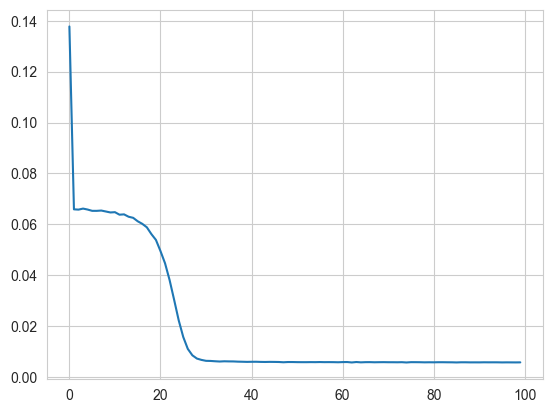

In [26]:
X = np.random.rand(300, 2)
y = (np.sin(X[:, 0]) + X[:, 1]**0.5 + np.random.randn(300) * 0.1).reshape(-1, 1)

pesos, historico = treinar_mlp(
    X, y,
    neurons_by_layer=[16, 16, 16],   # 2 camadas ocultas
    ativ_nome='relu',
    epochs=100,
    eta_i=0.01,
    eta_f=0.001,
    verbose=True
)

y_pred = prever(X, pesos, tanh)


plt.plot(historico)
plt.show()
